In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.callbacks import EarlyStopping

2023-09-23 11:38:31.644246: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_pickle('Annomi_VGGish.pkl')

In [3]:
# Get a dataframe where interlocutor is cleint
df_client = df[df['interlocutor'] == 'client']

# Get a dataframe where interlocutor is therapist
df_therapist = df[df['interlocutor'] == 'therapist']

# Preprocessing

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
import tensorflow as tf


In [5]:
# Split the df_therapist into train and test sets depending on the unique id of video_title
# The train set contains 80% of the data and the test set contains 20% of the data

# video_titles = df_client['video_title'].unique()

# train_video_titles, test_video_titles = train_test_split(video_titles, test_size=0.2, random_state=42)

# train_df = df_client[df_client['video_title'].isin(train_video_titles)]
# test_df = df_client[df_client['video_title'].isin(test_video_titles)]

In [6]:
# Train test split
# train_df, test_df = train_test_split(df_client, test_size=0.2, random_state=42)

train_df, test_df = train_test_split(df_therapist, test_size=0.2, random_state=42)

In [7]:
# labeling the y_train and y_test
# y_train_classes = train_df['client_talk_type']
# le = preprocessing.LabelEncoder()
# le.fit(y_train_classes)
# print(f'Original classes {le.classes_}')
# print(f'Corresponding numeric classes {le.transform(le.classes_)}')
# y_train = le.transform(y_train_classes)
# y_test_classes = test_df['client_talk_type']
# y_test = le.transform(y_test_classes)

In [8]:
# labeling the y_train and y_test
y_train_classes = train_df['main_therapist_behaviour']
le = preprocessing.LabelEncoder()
le.fit(y_train_classes)
print(f'Original classes {le.classes_}')
print(f'Corresponding numeric classes {le.transform(le.classes_)}')
y_train = le.transform(y_train_classes)
y_test_classes = test_df['main_therapist_behaviour']
y_test = le.transform(y_test_classes)

Original classes ['other' 'question' 'reflection' 'therapist_input']
Corresponding numeric classes [0 1 2 3]


In [9]:
# X_train and X_test

# X_train = train_df['client_vggish_emb']
# X_test = test_df['client_vggish_emb']

X_train = train_df['therapist_vggish_emb']
X_test = test_df['therapist_vggish_emb']

In [10]:
X_train.shape

(5152,)

In [11]:
def pad_sequence(sequence, maxlen):
    if isinstance(sequence, list):
        sequence = np.array(sequence)
        
    # Get the embedding size
    embedding_size = sequence.shape[-1]
    
    # Create a padded sequence filled with zeros
    padded_sequence = np.zeros((maxlen, embedding_size))
    
    # Copy the original sequence into the beginning of the padded sequence
    padded_sequence[:sequence.shape[0], :embedding_size] = sequence
    
    return padded_sequence

In [12]:
# Get the maximum sequence length
MAXLEN = max(X_train.apply(len).max(), X_test.apply(len).max())

# Use the above function to pad X_train and X_test
X_train_padded = np.array([pad_sequence(seq, MAXLEN) for seq in X_train])
X_test_padded = np.array([pad_sequence(seq, MAXLEN) for seq in X_test])


In [13]:
num_classes = len(le.classes_)
y_train_onehot = to_categorical(y_train, num_classes=num_classes)
y_test_onehot = to_categorical(y_test, num_classes=num_classes)


# Classification

In [14]:
def focal_loss(alpha=0.25, gamma=2.0):
    def focal_loss_fixed(y_true, y_pred):
        y_true = K.cast(y_true, dtype='float32')
        
        # Scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # Clip to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
        
        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)
        
        # Calculate Focal Loss
        loss = alpha * (1 - y_pred) ** gamma * cross_entropy
        
        # Sum the losses in mini_batch
        return K.sum(loss, axis=1)
    
    return focal_loss_fixed

# Save the best model
checkpoint_filepath = './best_model_vggish'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_f1_macro',
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_f1_macro', 
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    mode='max'  # Because we want to maximize the val_f1_macro value
)

def f1_macro(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision_val = precision(y_true, y_pred)
    recall_val = recall(y_true, y_pred)
    return 2*((precision_val * recall_val) / (precision_val + recall_val + K.epsilon()))



# Define the learning rate schedule
class WarmUpCosineDecayScheduler(tf.keras.callbacks.Callback):
    def __init__(self, learning_rate_base, total_steps, global_step_init=0, warmup_learning_rate=0.0,
                 warmup_steps=0, hold_base_rate_steps=0):
        super(WarmUpCosineDecayScheduler, self).__init__()
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.global_step = global_step_init
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.hold_base_rate_steps = hold_base_rate_steps
        self.learning_rates = []

    def on_batch_end(self, batch, logs=None):
        self.global_step = self.global_step + 1
        lr = self._decayed_lr(tf.float32)
        tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        self.learning_rates.append(lr)

    def _decayed_lr(self, var_type):
        warmup_learning_rate = tf.convert_to_tensor(self.warmup_learning_rate, var_type)
        learning_rate_base = tf.convert_to_tensor(self.learning_rate_base, var_type)
        global_step = tf.convert_to_tensor(self.global_step, var_type)
        warmup_steps = tf.convert_to_tensor(self.warmup_steps, var_type)
        total_steps = tf.convert_to_tensor(self.total_steps, var_type)
        hold_base_rate_steps = tf.convert_to_tensor(self.hold_base_rate_steps, var_type)

        learning_rate = tf.where(
            global_step < warmup_steps,
            warmup_learning_rate + ((learning_rate_base - warmup_learning_rate) *
                                    (global_step / warmup_steps)),
            learning_rate_base * tf.cos(
                np.pi * (global_step - warmup_steps - hold_base_rate_steps) / (total_steps - warmup_steps - hold_base_rate_steps))
        )
        return tf.where(global_step > (warmup_steps + hold_base_rate_steps), learning_rate, learning_rate_base)

# Approximate number of training steps
TOTAL_STEPS = int(len(X_train) / 32 * 20)  # 20 epochs
WARMUP_STEPS = int(TOTAL_STEPS * 0.1)

# Create the learning rate scheduler
lr_schedule = WarmUpCosineDecayScheduler(learning_rate_base=0.001,
                                         total_steps=TOTAL_STEPS,
                                         warmup_learning_rate=0.0,
                                         warmup_steps=WARMUP_STEPS)


In [15]:
embedding_size = X_train_padded.shape[-1]
input_shape = (MAXLEN, embedding_size)

In [16]:
input_shape

(803, 128)

In [17]:
model = Sequential()

model.add(LSTM(256, input_shape=(MAXLEN, embedding_size), return_sequences=True))
model.add(Dropout(0.1))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.1))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.1))

model.add(LSTM(32))
model.add(Dropout(0.1))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_macro])

2023-09-23 11:38:39.271851: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-23 11:38:39.277995: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-23 11:38:39.278250: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

s-bus-pci#L344-L355
2023-09-23 11:38:39.286347: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-23 11:38:39.286532: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-23 11:38:39.384210: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentat

In [18]:
history = model.fit(X_train_padded, y_train_onehot,
                    validation_data=(X_test_padded, y_test_onehot),
                    epochs=100, batch_size=8,
                    callbacks=[lr_schedule, model_checkpoint_callback, early_stopping])

Epoch 1/100


2023-09-23 11:38:47.585852: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2023-09-23 11:38:47.710626: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:625] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-09-23 11:38:47.727803: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb049d65900 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-23 11:38:47.727869: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2023-09-23 11:38:47.734374: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-23 11:38:47.870017: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pro

644/644 [==============================] - ETA: 0s - loss: 1.3637 - accuracy: 0.3069 - f1_macro: 0.0029
Epoch 1: val_f1_macro improved from -inf to 0.00000, saving model to ./best_model_vggish
INFO:tensorflow:Assets written to: ./best_model_vggish/assets


INFO:tensorflow:Assets written to: ./best_model_vggish/assets


644/644 [==============================] - 74s 107ms/step - loss: 1.3637 - accuracy: 0.3069 - f1_macro: 0.0029 - val_loss: 1.3494 - val_accuracy: 0.3533 - val_f1_macro: 0.0000e+00
Epoch 2/100
644/644 [==============================] - ETA: 0s - loss: 1.3598 - accuracy: 0.3073 - f1_macro: 0.0000e+00
Epoch 2: val_f1_macro did not improve from 0.00000
644/644 [==============================] - 59s 92ms/step - loss: 1.3598 - accuracy: 0.3073 - f1_macro: 0.0000e+00 - val_loss: 1.3501 - val_accuracy: 0.3533 - val_f1_macro: 0.0000e+00
Epoch 3/100
644/644 [==============================] - ETA: 0s - loss: 1.3580 - accuracy: 0.3090 - f1_macro: 0.0000e+00
Epoch 3: val_f1_macro did not improve from 0.00000
644/644 [==============================] - 59s 92ms/step - loss: 1.3580 - accuracy: 0.3090 - f1_macro: 0.0000e+00 - val_loss: 1.3462 - val_accuracy: 0.3533 - val_f1_macro: 0.0000e+00
Epoch 4/100
644/644 [==============================] - ETA: 0s - loss: 23728.4180 - accuracy: 0.2069 - f1_macro:

INFO:tensorflow:Assets written to: ./best_model_vggish/assets


644/644 [==============================] - 68s 106ms/step - loss: 23728.4180 - accuracy: 0.2069 - f1_macro: 0.1010 - val_loss: 145962.7188 - val_accuracy: 0.1452 - val_f1_macro: 0.1452
Epoch 5/100
644/644 [==============================] - ETA: 0s - loss: 895853.9375 - accuracy: 0.1549 - f1_macro: 0.1549
Epoch 5: val_f1_macro did not improve from 0.14519
644/644 [==============================] - 59s 92ms/step - loss: 895853.9375 - accuracy: 0.1549 - f1_macro: 0.1549 - val_loss: 2175097.0000 - val_accuracy: 0.1452 - val_f1_macro: 0.1452
Epoch 6/100
644/644 [==============================] - ETA: 0s - loss: 4287345.0000 - accuracy: 0.1549 - f1_macro: 0.1549
Epoch 6: val_f1_macro did not improve from 0.14519
644/644 [==============================] - 59s 92ms/step - loss: 4287345.0000 - accuracy: 0.1549 - f1_macro: 0.1549 - val_loss: 6685376.5000 - val_accuracy: 0.1452 - val_f1_macro: 0.1452
Epoch 7/100
644/644 [==============================] - ETA: 0s - loss: 8455992.0000 - accuracy: 0

In [19]:
# Classification report
best_model = load_model(checkpoint_filepath, custom_objects={'f1_macro': f1_macro})
y_pred = best_model.predict(X_test_padded)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_classes, target_names=le.classes_))

41/41 [==============================] - 3s 39ms/step
                 precision    recall  f1-score   support

          other       0.00      0.00      0.00       455
       question       0.00      0.00      0.00       364
     reflection       0.00      0.00      0.00       282
therapist_input       0.15      1.00      0.25       187

       accuracy                           0.15      1288
      macro avg       0.04      0.25      0.06      1288
   weighted avg       0.02      0.15      0.04      1288



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


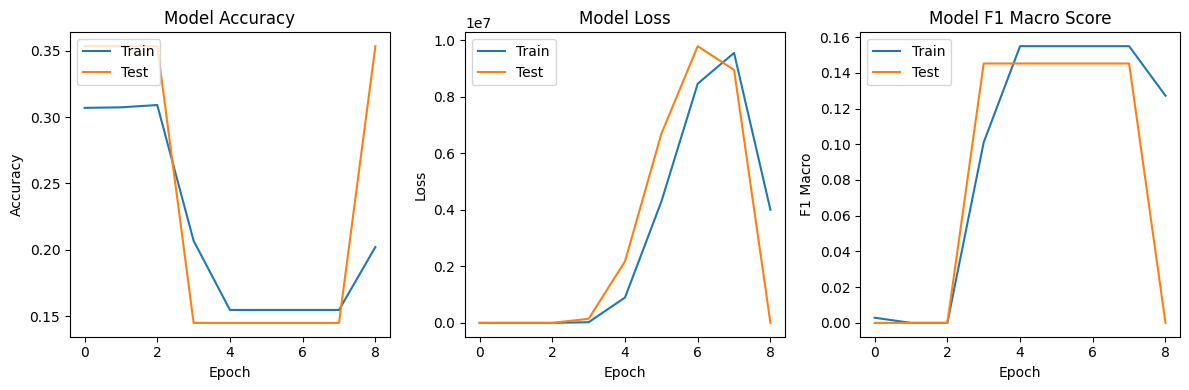

In [20]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation F1 Macro score
plt.subplot(1, 3, 3)
plt.plot(history.history['f1_macro'])
plt.plot(history.history['val_f1_macro'])
plt.title('Model F1 Macro Score')
plt.ylabel('F1 Macro')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()
